<a href="https://colab.research.google.com/github/bingxiaochen/ST-554-Project1/blob/main/Task2/Project1_Task2_Hui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Air pollutants are considered responsible for a range of respiratory diseases, and some compounds (e.g., benzene) are known to increase risk of cancer with prolonged exposure (De Vito et al., 2008). To explore how low-cost chemical sensors behave in real urban conditions, this project analyzes the [air quality dataset](https://archive.ics.uci.edu/dataset/360/air+quality) from the UCI machine learning repository . The dataset contains 9358 hourly measurements collected from March 2004 to February 2025 by an array of five metal-oxide chemical sensors deployed at street level in a heavily polluted Italian city. The dataset contains hourly concentrations for CO, Non Metanic Hydrocarbons (NMHC), benzene, Total Nitrogen Oxides (NOx), and Nitrogen Dioxide (NO2), and Ozone (O3), along with meteorological variables including temperature, relative humidity (RH%), and absolute humidity (AH).

The purpose of the project is to conduct an exploratory data analysis to investigate how sensor signals and environmental conditions related to the “true” benzene concentration, as well as to explore sensor behavior, cross-sensitivities, and drift phenomena documented in the original study. Details of the variables are available on the UCI air quality repository.


# Read in data and clean up data
To read in the dataset, we first need to install the ucimlrepo package via the follow code.

In [ ]:
!pip install ucimlrepo # install ucimlrepo package

Import the dataset for analysis

In [4]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)
X = air_quality.data.features
y = air_quality.data.targets

Check dataset structure and variable information.

In [36]:
X.head()     # check the dataset structure
X.info()     # check the data info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


- Clean up the data

Since we do not need the “true” reference values for CO, NMHC, NOx, or NO₂, we can remove those columns from the dataset and rename C6H6(GT), PT08.S1(CO), PT08.S2(NMHC), PT08.S3(NOx), PT08.S4(NO₂), and PT08.S5(O₃) to more intuitive and easy-to-understand variable names. We stored the dataframe to a new one named X_df.

In [39]:
# drop variables not to be analysed and rename variables
X_df = X.drop(columns = ["CO(GT)", "NMHC(GT)", "NOx(GT)", "NO2(GT)"]) \
    .rename(columns = {"C6H6(GT)" : "Ben",          # rename variables
                        "PT08.S1(CO)": "CO",
                        "PT08.S2(NMHC)" : "NMHC",
                        "PT08.S3(NOx)" : "NOx",
                        "PT08.S4(NO2)" : "NO2",
                        "PT08.S5(O3)" : "O3" })
X_df.head()                                          # check the new data frame

,Date,Time,CO,Ben,NMHC,NOx,NO2,O3,T,RH,AH
0,3/10/2004,18:00:00,1360,11.9,1046,1056,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,1292,9.4,955,1174,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,1402,9.0,939,1140,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,1376,9.2,948,1092,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1272,6.5,836,1205,1490,1110,11.2,59.6,0.7888


- Check missing values and replace them with nan

    Based on information from the UCI Air Quality website, missing values in the dataset are coded as –200. Therefore, we need to remove all rows containing this value.

In [40]:
import numpy as np                  # import numpy module
X_df = X_df.replace(-200, np.nan)   # replaced missing values with 'NAN'
X_df.isna().sum()                   # count how many missing values in each column

,0
Date,0
Time,0
CO,366
Ben,366
NMHC,366
NOx,366
NO2,366
O3,366
T,366
RH,366


Since there are equal numbers of missing values in the data frame, so we will remove those missing values for further analysis.

- Drop the missing values and conduct a quick summary of the variables

In [35]:
X_df = X_df.dropna()     # drop the missing values represented as 'NaN'
X_df.isna().sum()        # Check if there are still missing values in the data frame
X_df.describe().round(4) # Get the summary table to understand the numberic varviables

,CO,Ben,NMHC,NOx,NO2,O3,T,RH,AH
count,8991.0000,8991.0000,8991.0000,8991.0000,8991.0000,8991.0000,8991.0000,8991.0000,8991.0000
mean,1099.8332,10.0831,939.1534,835.4936,1456.2646,1022.9061,18.3178,49.2342,1.0255
std,217.0800,7.4498,266.8314,256.8173,346.2068,398.4843,8.8321,17.3169,0.4038
min,647.0000,0.1000,383.0000,322.0000,551.0000,221.0000,-1.9000,9.2000,0.1847
25%,937.0000,4.4000,734.5000,658.0000,1227.0000,731.5000,11.8000,35.8000,0.7368
50%,1063.0000,8.2000,909.0000,806.0000,1463.0000,963.0000,17.8000,49.6000,0.9954
75%,1231.0000,14.0000,1116.0000,969.5000,1674.0000,1273.5000,24.4000,62.5000,1.3137
max,2040.0000,63.7000,2214.0000,2683.0000,2775.0000,2523.0000,44.6000,88.7000,2.2310


Across all variables, the dataset contains 8,991 complete observations for each vaiable after removing rows with missing values. The pollutant sensor readings (CO, Ben, NMHC, NOx, NO₂, O₃) show substantial variability, with wide ranges between their minimum and maximum values, indicating fluctuating air-quality conditions over time. All pollutant variables exhibit right-skewed distributions, as their upper quartiles and maximum values are noticeably higher than their medians.

Temperature (T) ranges from slightly below freezing (-1.9°C) to warm conditions (44.6°C), reflecting seasonal variation. Relative humidity (RH) spans from very dry (9.2%) to highly humid (88.7%), while absolute humidity (AH) shows a narrower range but still varies meaningfully across the year. Overall, the summary statistics suggest the dataset with strong temporal and environmental variability, suitable for exploring sensor behavior and pollutant relationships.

## Summary of the benzene, C6H6(GT), at different levels/combinations of other variables

- Benzene across months

- Investigate the distribution of variables

We developed a plotting function that produces a histogram for any selected variable, with an optional user-defined bin size. The function takes three inputs — the dataframe (X_df), the variable name, and the desired number of bins — and returns a histogram showing the frequency distribution of the variable across its valure (e.g., concentration) range.

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_hist(df, var, bins = None):
    """
    Fuction to plot histgram showing the distribution of
    selected variable with an optional user-defined bin size.
    """
    df[var].plot.hist(bins = bins)
    if bins != None:
        bins = bins
    else:
         bins = None
    plt.xlabel(f"Value of {var}")
    plt.title(f"Histogram of {var} for air quality")
    plt.show()
    return None

Test the function with benzene variable.

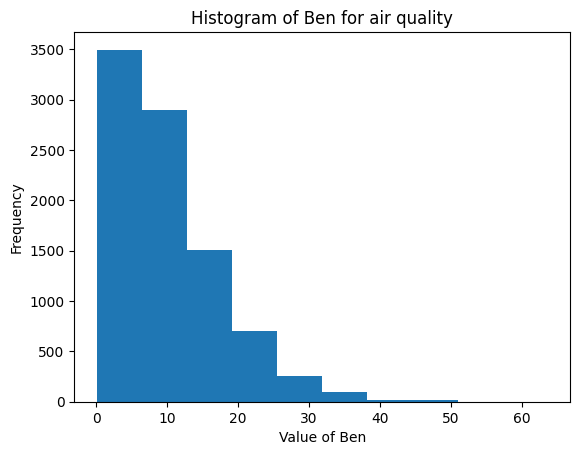

In [70]:
plot_hist(X_df, "Ben", bins = 10)

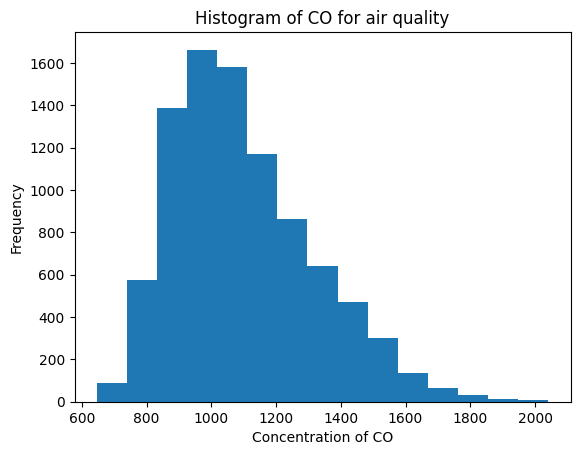

In [68]:
plot_hist(X_df, "CO", bins = 15 )